In [1]:
# Usual suspect
import numpy as np
import sys
import math
import pandas as pd
from typing import Tuple
sys.path.insert(1, '../muograph')

%reload_ext autoreload
%autoreload 2

In [2]:
input_hits_csv = "../data/1M_gen_2hods_30cm_panel_gap_barrel_voi.csv"
pd.read_csv(input_hits_csv).columns

Index(['Event', 'X0', 'Y0', 'Z0', 'Edep0', 'X1', 'Y1', 'Z1', 'Edep1', 'X2',
       'Y2', 'Z2', 'Edep2', 'X3', 'Y3', 'Z3', 'Edep3', 'X4', 'Y4', 'Z4',
       'Edep4', 'X5', 'Y5', 'Z5', 'Edep5', 'E', 'Theta'],
      dtype='object')

# **Muon hits**

In [4]:
from hits.hits import get_hits_from_csv

hits_in = get_hits_from_csv(
    csv_file=input_hits_csv,
    plane_labels=(0,1,2),
    )

hits_out = get_hits_from_csv(
    csv_file=input_hits_csv,
    plane_labels=(3,4,5),
    )

# **Tracking**


In [62]:
output_dir = "../output/test/"

from tracking.tracking import Tracking
tracks_in = Tracking(hits = hits_in, label = "above", output_dir=output_dir)
tracks_out = Tracking(hits = hits_out, label = "below", output_dir=output_dir)

In [63]:
from tracking.tracking import TrackingMST

# Load from tracking files
tracking_files = [
    "../output/test/" + "tracks_above.hdf5",
    "../output/test/" + "tracks_below.hdf5"
]
mst = TrackingMST(tracking_files = tracking_files)

# Load from tracking instances
# mst = TrackingMST(trackings=(tracks_in, tracks_out))


/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output directory already exists

Tracking attributes loaded from ../output/test/tracks_above.hdf5

Tracking attributes loaded from ../output/test/tracks_below.hdf5


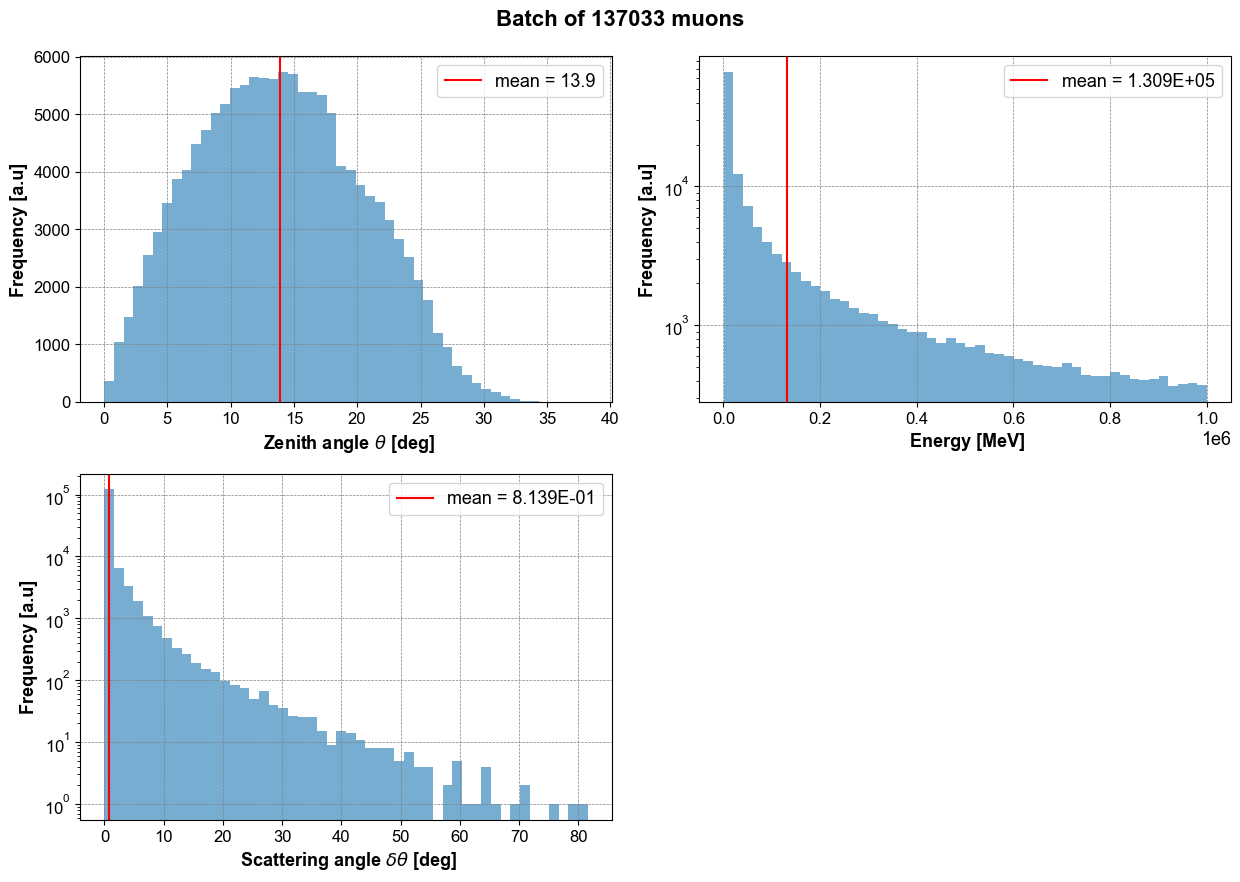

In [96]:
mst.plot_muon_features(figname="../output/test_plot")

# **Reconstruction**

**Angle Statistic Reconstruction**

In [8]:
from volume.volume import Volume
voi = Volume(position = [0,0,-1200],dimension=[1000,600,600],voxel_width=20)

In [33]:
from reconstruction.asr import ASR
asr = ASR(voi=voi, tracking=mst, output_dir=output_dir)

In [34]:
asr = ASR(
    voi=voi, 
    tracking=mst, 
    output_dir=output_dir, 
    triggered_vox_file="../output/test/" + "triggered_voxels.hdf5")



../output/test directory already exists
Loading trigerred voxels from ../output/test/triggered_voxels.hdf5


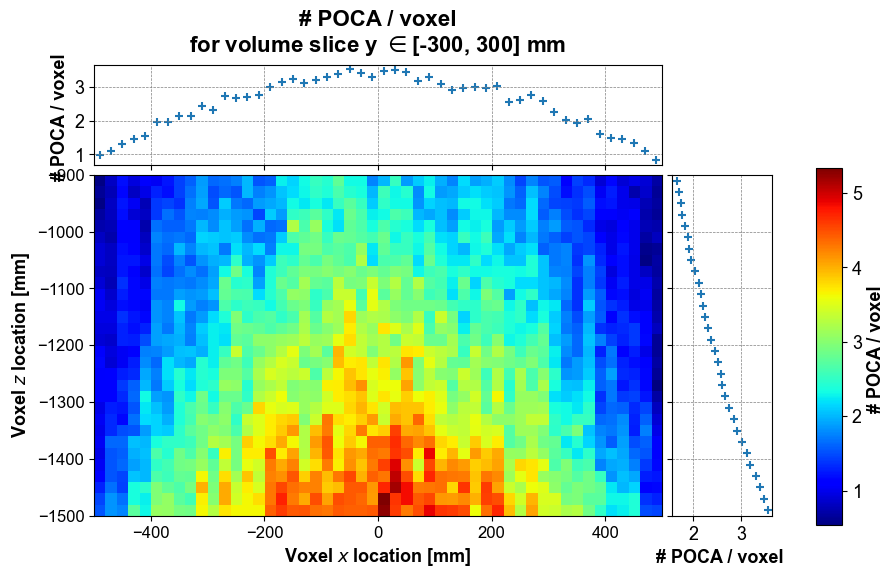

In [39]:
asr.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=asr.n_mu_per_vox,
    dim=1,
    voi_slice=(0, asr.voi.n_vox_xyz[1] - 1),
    pred_label="# POCA / voxel",
    pred_unit="",
)

In [30]:
from functools import partial 

asr.asr_params = {
        "score_method": partial(np.quantile, q=0.8),
        "p_range": (0.0, 10000000),  # MeV
        "dtheta_range": (0.1 * math.pi / 180, 10 * math.pi / 180),
        "use_p": False,
    }

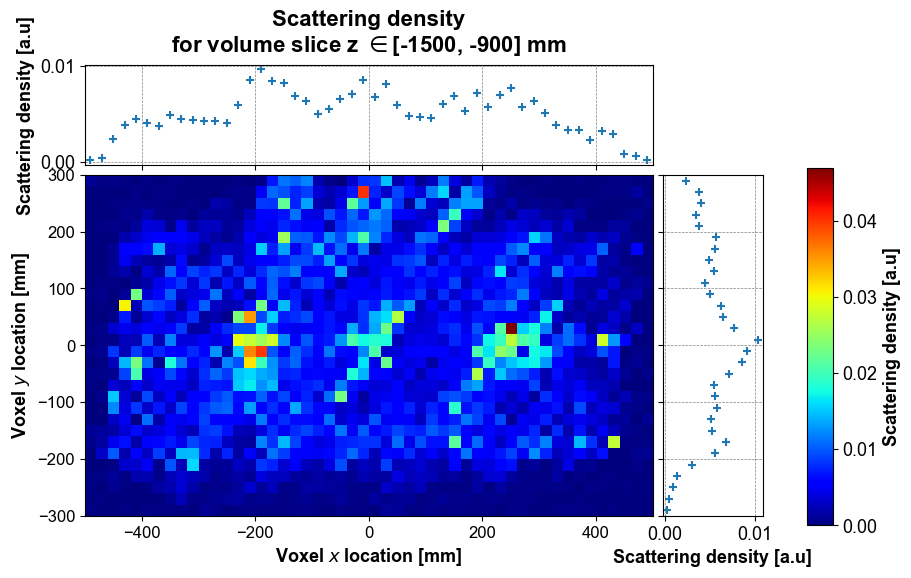

In [33]:
asr.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=asr.xyz_voxel_pred,
    dim=2,
    voi_slice=(0, asr.voi.n_vox_xyz[2] - 1),
)

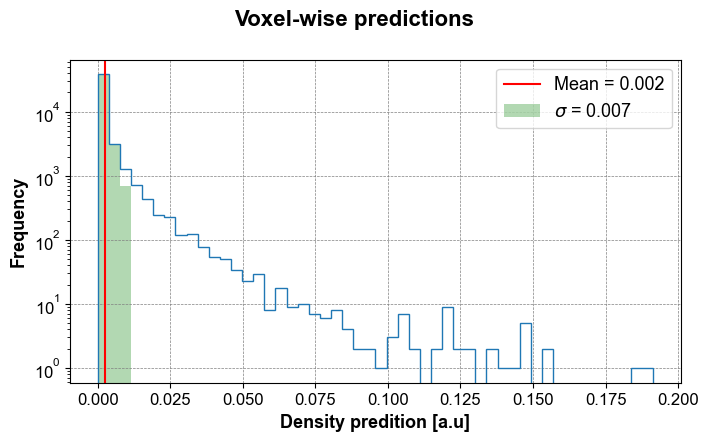

In [29]:
asr.plot_pred_1D(asr.xyz_voxel_pred, log = True)

In [36]:
from utils.tools import apply_gaussian_filter
smooth_scores = apply_gaussian_filter(asr.xyz_voxel_pred, [.7, .7, .7])

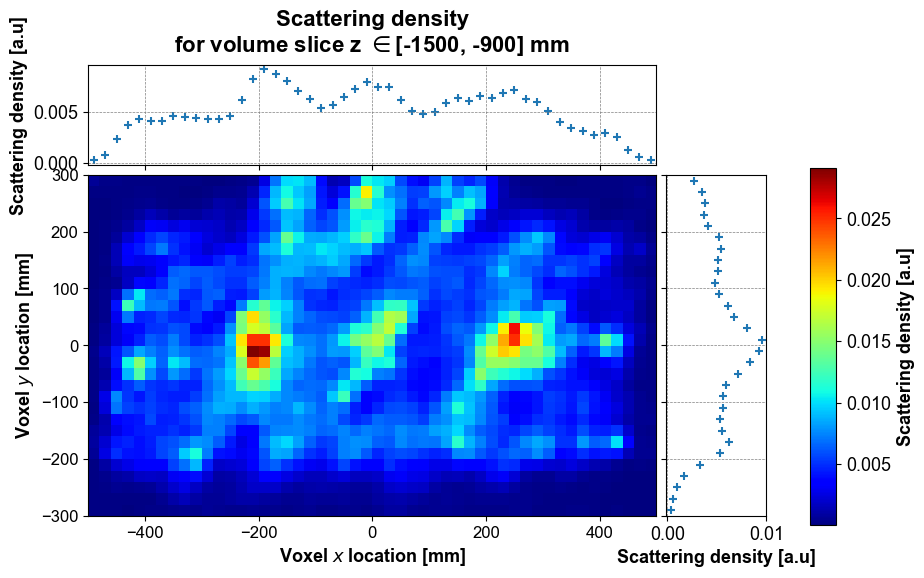

In [37]:
asr.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=smooth_scores,
    dim=2,
    voi_slice=(0, asr.voi.n_vox_xyz[2] - 1),
)

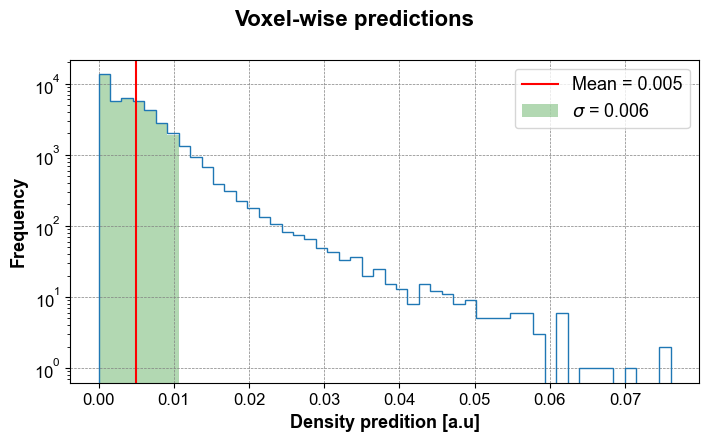

In [38]:
asr.plot_pred_1D(smooth_scores, log = True)

**Point Of Closest Approach**

In [9]:
from reconstruction.poca import POCA
poca = POCA(tracking = mst, voi=voi, output_dir=output_dir)


../output/test directory already exists

Assigning voxel to each POCA point:


Class attributes saved at ../output/test/poca.hdf5


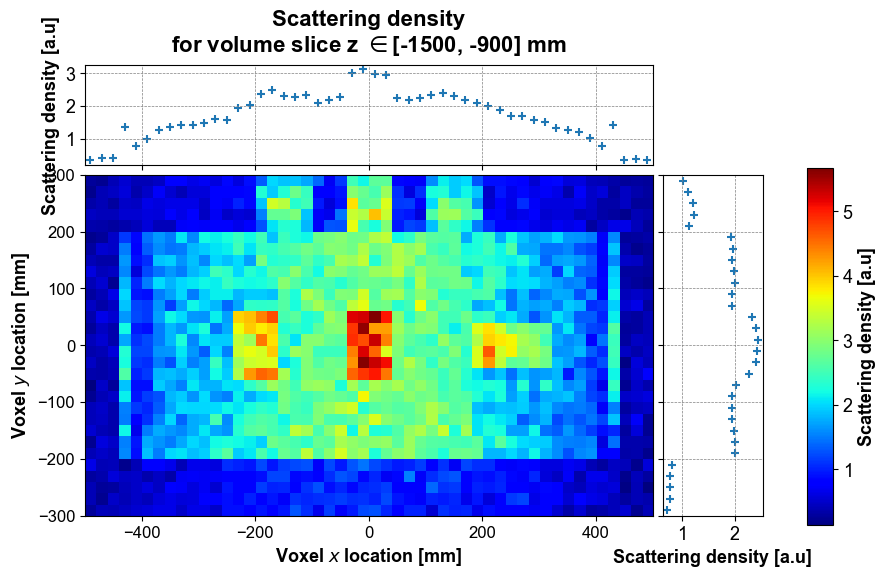

In [11]:
poca.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=poca.n_poca_per_vox,
    dim=2,
    voi_slice=(0, poca.voi.n_vox_xyz[2] - 1),
)

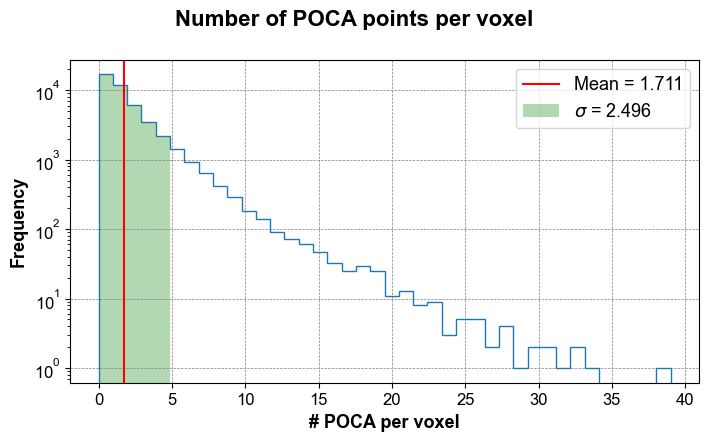

In [25]:
poca.plot_pred_1D(
    poca.n_poca_per_vox,
    title="Number of POCA points per voxel",
    x_label="# POCA per voxel",
    log = True, 
    n_bins = 40)

In [28]:
from utils.tools import apply_gaussian_filter
smooth_pocas = apply_gaussian_filter(poca.n_poca_per_vox, [.7, .7, .7])

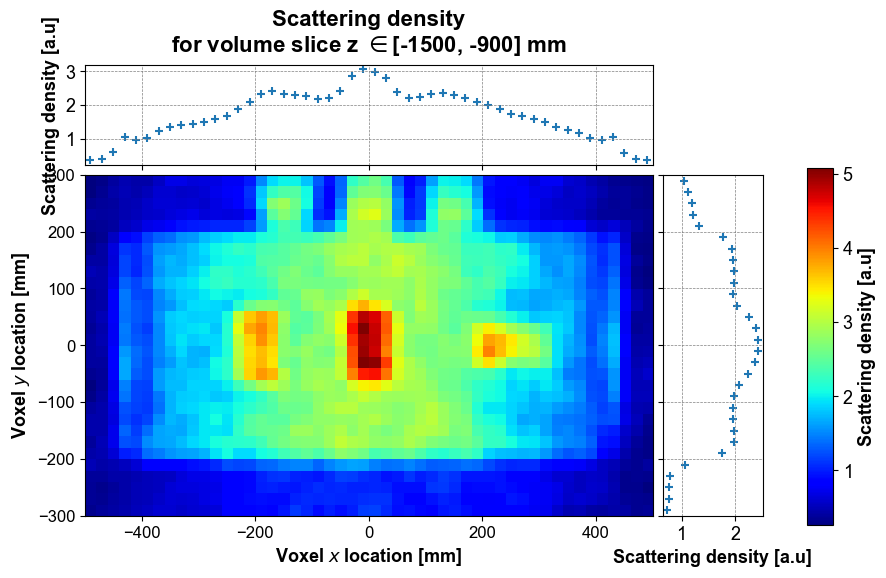

In [29]:
poca.plot_pred_slice(
    voi=poca.voi,
    xyz_voxel_preds=smooth_pocas,
    dim=2,
    voi_slice=(0, poca.voi.n_vox_xyz[2] - 1),
)

In [97]:
voi.n_vox_xyz

(50, 30, 30)

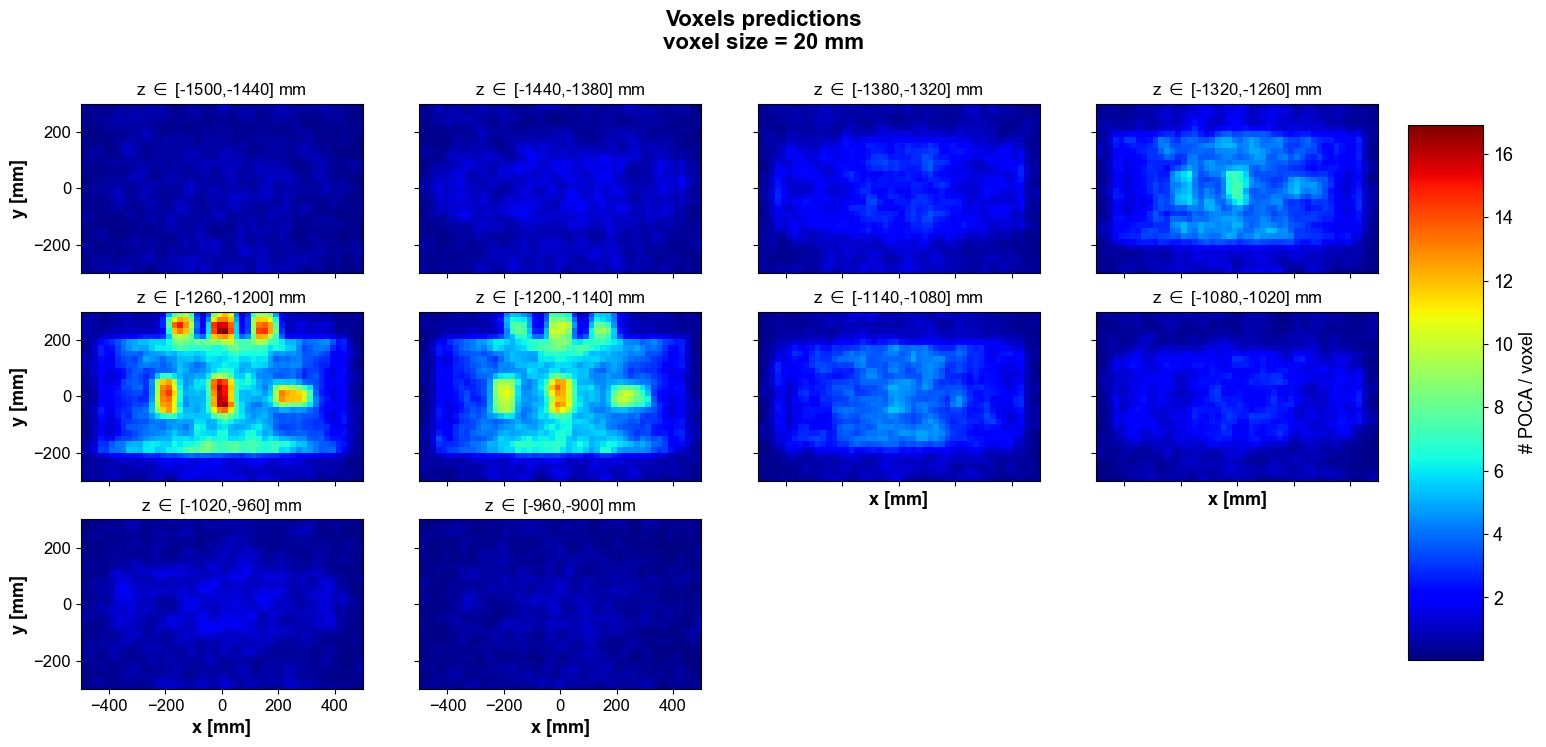

In [98]:
poca.plot_pred_by_slice(
    voi = poca.voi,
    xyz_voxel_preds=smooth_pocas,
    filename ="../output/test_pocas_slice",
    nslice_per_plot=3,
    ncols = 4,
    dim = 2,
    colorbar_label="# POCA / voxel",
    )

**Binned Clustered Algorithm**

In [57]:
from reconstruction.binned_clustered import BCA

bca = BCA(voi = voi, tracking = mst, output_dir=output_dir)


../output/test directory already exists
Copmute bcs scores

../output/test/method_quantile_q=0.5_metric_log_0.00_1.05_rad_0_10000000_MeV_n_min_max_3_10_use_p_False directory already exists

Assigning voxel to each POCA point:


Class attributes saved at ../output/test/poca.hdf5


In [101]:
from functools import partial

bca.bca_params = {
    "n_max_per_vox": 20, 
    "n_min_per_vox": 4, 
    "score_method": partial(np.quantile, q=0.8),
    "metric_method": partial(np.log),
    "p_range": (0, 1000000),
    "dtheta_range": (0.1 * math.pi / 180, 20 * math.pi / 180)
    }


../output/test/method_quantile_q=0.8_metric_log_0.00_0.35_rad_0_1000000_MeV_n_min_max_4_20_use_p_False directory created


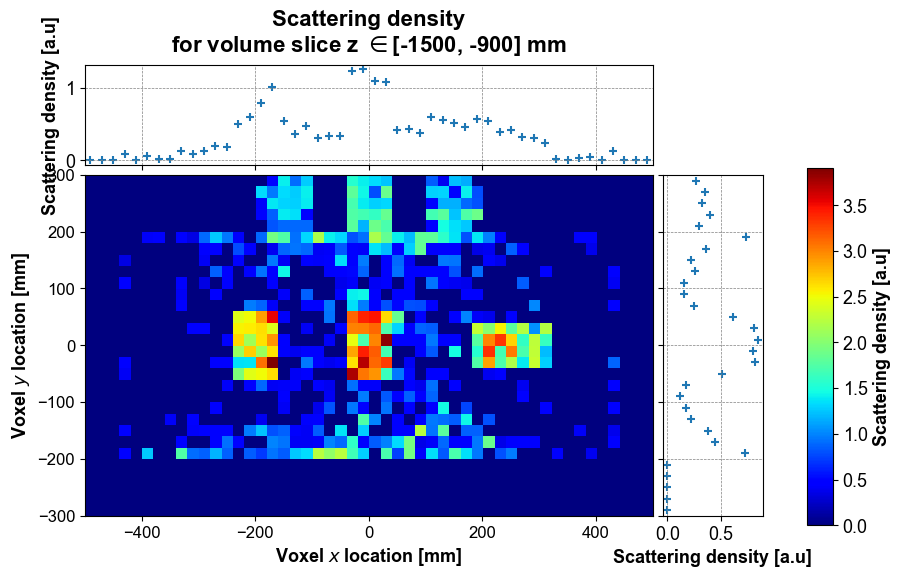

In [102]:
bca.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=bca.xyz_voxel_pred,
    dim=2,
    voi_slice=(0, bca.voi.n_vox_xyz[2] - 1),
)

In [105]:
smooth_bca = apply_gaussian_filter(bca.xyz_voxel_pred, [.7, .7, .7])

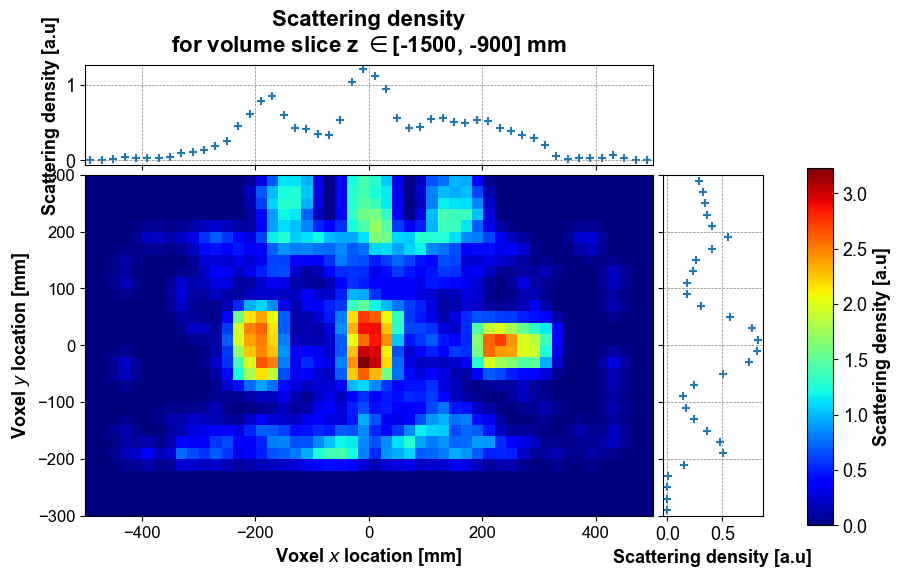

In [106]:
bca.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=smooth_bca,
    dim=2,
    voi_slice=(0, bca.voi.n_vox_xyz[2] - 1),
)

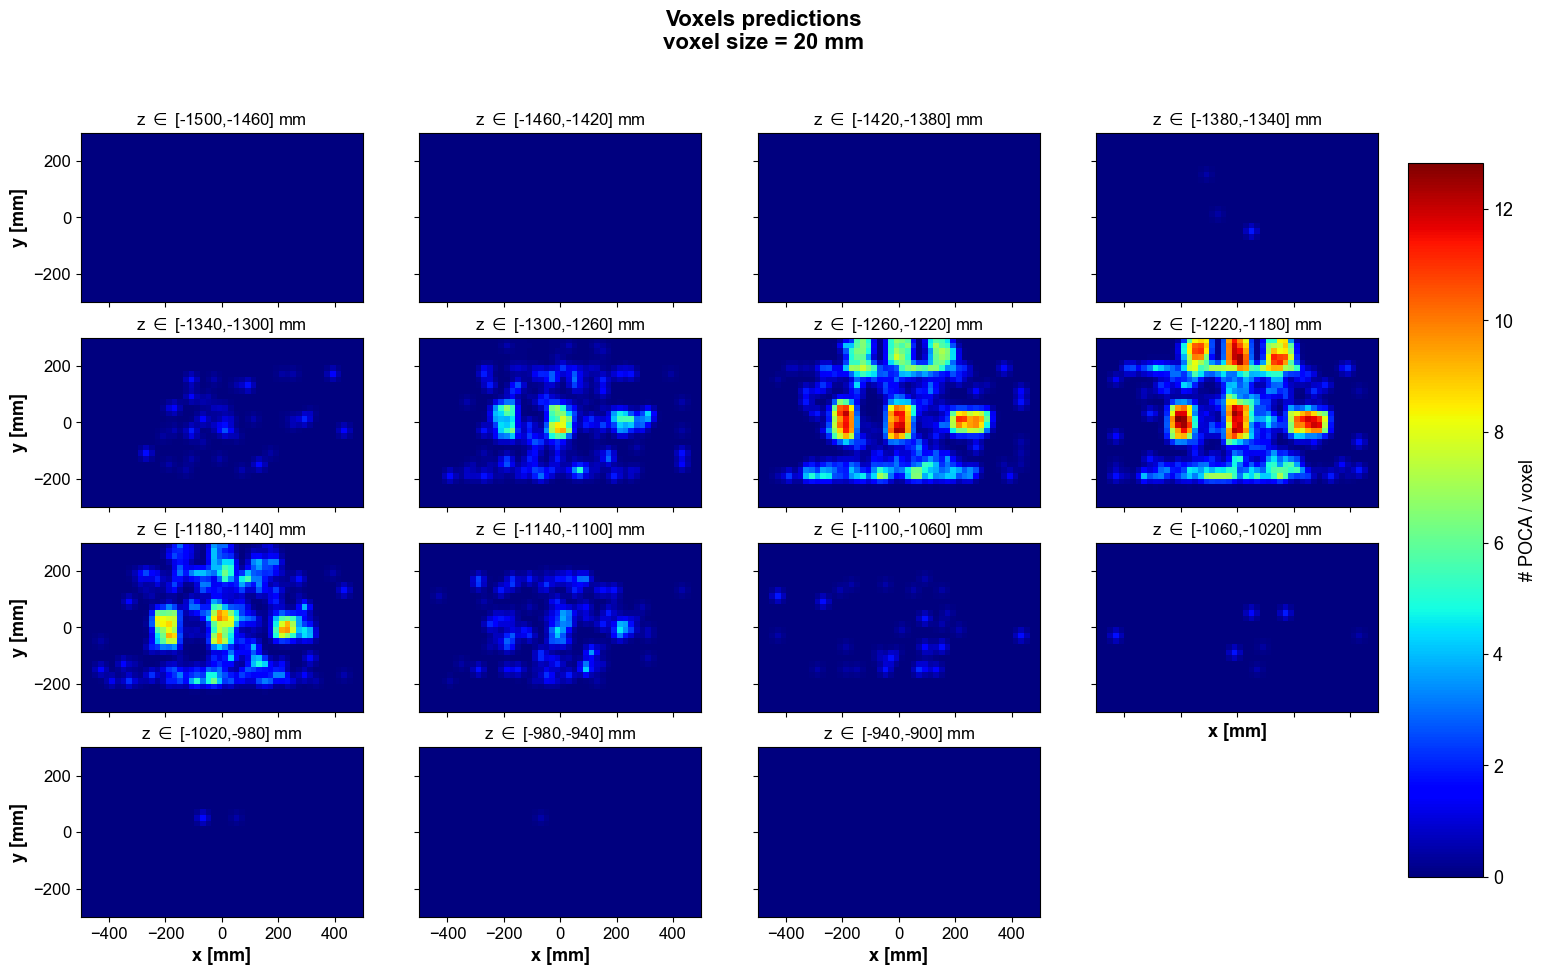

In [108]:
poca.plot_pred_by_slice(
    voi = poca.voi,
    xyz_voxel_preds=smooth_bca,
    filename ="../output/test_pocas_slice",
    nslice_per_plot=2,
    ncols = 4,
    dim = 2,
    colorbar_label="# POCA / voxel",
    )